In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
import glob
import wandb
import os
import torch.optim as optimizers
import pandas as pd
from copy import deepcopy
from ml_collections import ConfigDict 
import tqdm
import torch.nn.functional as F
import torch
import torch.nn as nn
from collections import defaultdict
import yaml
from sklearn.metrics import roc_auc_score
import networkx as nx

import sys
sys.path.append("../../src")
import dfs_code 
from dfs_transformer import collate_downstream, DFSCodeSeq2SeqFC, TrainerGNN, KarateClubDataset
#torch.multiprocessing.set_sharing_strategy('file_system')

import torch_geometric.nn as tnn
import networkx as nx
from torch_geometric.loader import DataLoader


In [3]:
config = wandb.config
config.graph_file = "../../datasets/karateclub/reddit_threads/reddit_edges.json"
config.label_file = "../../datasets/karateclub/reddit_threads/reddit_target.csv"
config.batch_size = 50
config.n_epochs = 5
config.learning_rate = 0.01
config.rep = 1
config.max_edges = 200
config.n_samples = 1000# None -> all
config.n_channels = 32
config.n_layers = 2
config.model = "tnn.models.GCN"
config.readout = "tnn.global_mean_pool"
config.num_workers = 5
config.training = {}

In [4]:
run = wandb.init(mode="online", project="karateclub-twitch", entity="dfstransformer", 
                 config=config, job_type="evaluation", name="GCN-ones")

2022/10/29 18:55:48	ERROR	wandb.jupyter	Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eth-compiler-opters (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [5]:
with open(config.graph_file, 'r') as f:
    graph_dict = json.load(f)
label_df = pd.read_csv(config.label_file)

In [6]:
label_df['target'].sum()/len(label_df)

0.5124133380603483

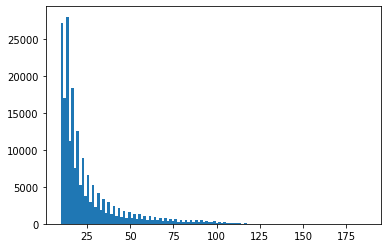

In [7]:
from matplotlib import pyplot as plt
n_edges = [len(graph) for graph in graph_dict.values()]
plt.hist(n_edges, bins='rice')
plt.show()

In [8]:
dataset = KarateClubDataset(config.graph_file, config.label_file, max_n=config.n_samples, max_edges=config.max_edges)

1000it [00:00, 4999.50it/s]
1000it [00:01, 596.31it/s]


In [9]:
len(dataset)

1000

In [10]:
dim_input = dataset[0].x.shape[1]

In [11]:
from einops import rearrange
gnn = eval(config.model)(dim_input, config.n_channels, config.n_layers, 600)


model = tnn.Sequential('x, edge_index, batch', [
    (gnn, 'x, edge_index -> x'),
    (eval(config.readout), 'x, batch -> x'),
    (nn.Linear(600, 2),'x -> x')
])

In [12]:
n = len(dataset)
n_train = int(0.8*n)
n_valid = 0
n_test = n - n_train - n_valid
perm = np.random.permutation(len(dataset))
train_idx = torch.tensor(perm[:n_train], dtype=torch.long)
valid_idx = torch.tensor(perm[n_train:n_train+n_valid].tolist(), dtype=torch.long)
test_idx = torch.tensor(perm[n_train+n_valid:].tolist(), dtype=torch.long)

In [13]:
ce = nn.CrossEntropyLoss()
#ce = nn.BCEWithLogitsLoss()

In [14]:
trainloader = DataLoader(dataset, sampler=torch.utils.data.SubsetRandomSampler(train_idx), 
                         batch_size=config.batch_size, num_workers=config.num_workers)
validloader = DataLoader(dataset, sampler=torch.utils.data.SubsetRandomSampler(valid_idx), 
                         batch_size=config.batch_size, num_workers=config.num_workers)
testloader = DataLoader(dataset, sampler=torch.utils.data.SubsetRandomSampler(test_idx), 
                        batch_size=config.batch_size, num_workers=config.num_workers)

In [15]:
def loss_pretrain(pred, y, l=nn.MSELoss()):
    return l(pred, y)

def loss(pred, y, ce=ce):
    return ce(pred, y.squeeze())

def auc(pred, y):
    try:
        return roc_auc_score(y.detach().cpu().numpy(), pred.detach().cpu().numpy()[:, 1])
    except ValueError:
        return torch.tensor(0.)
    #return roc_auc_score(y.detach().cpu().squeeze().numpy(), pred.detach().cpu().squeeze().numpy())
    

In [19]:
trainer = TrainerGNN(model, trainloader, loss, metrics={'auc': auc}, n_epochs=config.n_epochs, lr=config.learning_rate, validloader=testloader, 
                  es_period=n_train//config.batch_size, lr_adjustment_period=10*n_train//config.batch_size//4, wandb_run=run,
                  clip_gradient_norm=None, lr_patience=5, es_patience=20)

In [20]:
trainer.fit()

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [444554], which does not match the required output shape [1331, 334]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [5560], which doe

/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [4472], which does not match the required output shape [2236, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [379090], which does not match the required output shape [1135, 334]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t 

/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [4688], which does not match the required output shape [2344, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [5172], which does not match the required output shape [2586, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by r

/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [4592], which does not match the required output shape [2296, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
Epoch 1: loss 0.613758 0.7583:  31%|█████████████████████████████████████████████                                                                                                   | 5/16 [00:01<00:02,  5.44it/s]/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [361054], which does 

/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [4744], which does not match the required output shape [2, 2372]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [5096], which does not match the required output shape [2548, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by r

/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [5580], which does not match the required output shape [2790, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [424180], which does not match the required output shape [1270, 334]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t 

/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [4692], which does not match the required output shape [2, 2346]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [4692], which does not match the required output shape [2346, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by r

Epoch 2: loss 0.494484 0.8582:  50%|████████████████████████████████████████████████████████████████████████                                                                        | 8/16 [00:00<00:00, 15.46it/s]/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [351034], which does not match the required output shape [1051, 334]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [4488], which doe

/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [5596], which does not match the required output shape [2798, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
  0%|                                                                                                                                                                                        | 0/4 [00:00<?, ?it/s]/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [429524], which does 

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [438542], which does not match the required output shape [1313, 334]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [396124], which d

/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [5196], which does not match the required output shape [2598, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [5224], which does not match the required output shape [2612, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by r

/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [4468], which does not match the required output shape [2234, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [4248], which does not match the required output shape [2124, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by r

/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [5004], which does not match the required output shape [2502, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [5108], which does not match the required output shape [2, 2554]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by r

/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [5596], which does not match the required output shape [2, 2798]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [4096], which does not match the required output shape [2, 2048]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by r

EarlyStopping counter: 1 out of 20


  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [362390], which does not match the required output shape [1085, 334]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [342016], which d

/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [4640], which does not match the required output shape [2320, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
Epoch 4: loss 0.544922 0.8331:   6%|█████████                                                                                                                                       | 1/16 [00:00<00:05,  2.56it/s]/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [342684], which does 

/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [5320], which does not match the required output shape [2, 2660]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [5320], which does not match the required output shape [2660, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by r

/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [5976], which does not match the required output shape [2988, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [5508], which does not match the required output shape [2, 2754]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by r

/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [4312], which does not match the required output shape [2156, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [5196], which does not match the required output shape [2, 2598]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by r

/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [4736], which does not match the required output shape [2, 2368]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [5052], which does not match the required output shape [2, 2526]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by r

/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [413826], which does not match the required output shape [1239, 334]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [4032], which does not match the required output shape [2016, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t 

/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [5376], which does not match the required output shape [2, 2688]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [361388], which does not match the required output shape [1082, 334]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t 

  0%|                                                                                                                                                                                        | 0/4 [00:00<?, ?it/s]/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [352370], which does not match the required output shape [1055, 334]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/home/chrisw/miniconda3/envs/py39/lib/python3.9/site-packages/torch_geometric/data/collate.py:147: UserWarning: An output with one or more elements was resized since it had shape [451902], which d

Epoch 5: loss 0.518722 0.8505: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.13it/s]


EarlyStopping counter: 1 out of 20
